In [ ]:
# Librerie principali

import numpy as np # linear algebra
import pandas as pd
import geopandas as gpd
import zipfile
import sklearn
import warnings
import json
warnings.filterwarnings('ignore')
from datetime import datetime
import statsmodels.api as sm
import seaborn as sns
from matplotlib import pyplot as plt
import folium
import pickle

# Model Libraries
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance

# Testing libraries
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report, roc_curve, auc

# !pip install yellowbrick
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import LearningCurve

se si vuole caricare solo la tabella finale unificata

In [2]:
trans_final = pd.read_pickle('./trans_final.pkl')
trans_final.head()

,id_trans,client_id_trans,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,day,time,...,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,years_to_retire,mcc_description
0,7475327,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,2010-01-01,00:01:00,...,594 Mountain View Street,46.80,-100.76,23679.0,48277.0,110153.0,740,4,37,Miscellaneous Food Stores
1,7475328,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,2010-01-01,00:02:00,...,604 Pine Street,40.80,-91.12,18076.0,36853.0,112139.0,834,5,19,Department Stores
2,7475329,1129,102,80.00,Swipe Transaction,27092,Vista,CA,2010-01-01,00:02:00,...,2379 Forest Lane,33.18,-117.29,16894.0,34449.0,36540.0,686,3,16,Money Transfer
3,7475331,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,2010-01-01,00:05:00,...,903 Hill Boulevard,41.42,-87.35,26168.0,53350.0,128676.0,685,5,15,Money Transfer
4,7475332,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,2010-01-01,00:06:00,...,166 River Drive,38.86,-76.60,33529.0,68362.0,96182.0,711,2,18,Drinking Places (Alcoholic Beverages)


In [ ]:
trans_final.columns

Estrazione delle tabelle e visualizzazione della corretta estrazione

In [ ]:
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
  with zip_ref.open('transactions_data.csv') as f:
        trans = pd.read_csv(f)
  with zip_ref.open('users_data.csv') as f:
        users = pd.read_csv(f)
  with zip_ref.open('cards_data.csv') as f:
        cards = pd.read_csv(f)


In [ ]:
trans.head()

In [ ]:
cards.head()

In [ ]:
users.head()

Informazioni riguardanti il dataset

In [ ]:
trans.info()

Converto il campo amount in float32 togliendo il valore del dollaro e faccio il cast a stringa per il campo zip, successivamente si scompone la colonna date che è in formato datetime in date e time

In [ ]:
trans.replace(r"['$']", '', regex = True, inplace=True)
trans['amount'] = trans['amount'].astype('float32')
trans['day'] = pd.to_datetime(trans['date']).dt.date
trans['time'] = pd.to_datetime(trans['date']).dt.time

Rilevamento valori NaN nella tabella trans

In [ ]:
trans.isna().sum(axis=0)

I valori NaN nei campi merchant_city e zip possono essere dati dal fatto che sono negozi online. Riempiamo quei campi con ONLINE quando merchant_city è ONLINE. Si ignorano i campi NaN dello zip poiché non verrà utilizzato nelle successive analisi.

In [ ]:
trans.loc[ trans['merchant_city'].str.upper() =='ONLINE','merchant_state'] = "ONLINE"

In [ ]:
trans.isna().sum(axis=0)

In [ ]:
trans.info()

Eliminazione delle colonne che non sono di interesse

In [ ]:
trans.drop(['date', 'zip','errors'], axis=1, inplace=True)

In [ ]:
trans.head()

informazioni riguardanti cards_data

In [ ]:
cards.info()

In [ ]:
cards['expires'] = pd.to_datetime(cards['expires'], format = "%m/%Y")
cards['acct_open_date'] = pd.to_datetime(cards['acct_open_date'], format = "%m/%Y")
cards['card_valid_month'] = (cards['expires'].dt.year- cards['acct_open_date'].dt.year)*12 + (cards['expires'].dt.month - cards['acct_open_date'].dt.month)

si fa diventare il campo credit limit un float eliminando il simbolo del dollaro


In [ ]:
cards['credit_limit'] = (cards['credit_limit'].replace(r"['$']",'',regex= True)).astype('float32')

rilevamento valori NaN nella tabella cards_data

In [ ]:
cards.isna().sum(axis=0)

In [ ]:
cards.head()

informazioni riguardanti trans_final

In [ ]:
users.info()

rilevamenti valori NaN nella tabella trans_final

In [ ]:
users.isna().sum(axis=0)

converto i campi per_capita_income, yearly_income e totale_dept in float32 e rimuovo da essi il simbolo del dollaro.

In [ ]:
users = users.replace(r"['$']", '', regex = True)
users['per_capita_income'] = users['per_capita_income'].astype('float32')
users['yearly_income'] = users['yearly_income'].astype('float32')
users['total_debt'] = users['total_debt'].astype('float32')

calcolo degli anni per andare in pensione, se già in pensione valore 0


In [ ]:
users['years_to_retire'] = np.where(users['retirement_age'] >= users['current_age'],
                                    users['retirement_age'] - users['current_age'],0 )

In [ ]:
users.head()

apro e analizzo il file json

In [ ]:
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
  with zip_ref.open('train_fraud_labels.json') as f:
        fraud_trans = pd.read_json(f)

visualizzo la struttura del file

In [ ]:
fraud_trans.head()

controllo se ci sono falori nulli

In [ ]:
fraud_trans.isna().sum()

cambio i valori 'No' in 0 e i valori 'Yes' in 1 per poter andare ad utilizzare questo campo nelle successive analisi

In [ ]:
fraud_trans['fraud'] = [0 if item == 'No' else 1 for item in fraud_trans['target']]

 modifico il file potermi poi connettere alla tabella delle transazioni

In [ ]:
fraud_trans.drop('target',axis=1, inplace=True)
fraud_trans.reset_index(inplace=True)

struttura finale

In [ ]:
fraud_trans.head()

Unificazione delle tabelle

In [ ]:
## join delle tabelle trans e fraud
trans_final = pd.merge(trans, fraud_trans, left_on='id',right_on = 'index', how = 'left')

## join tabella trans + fraud e cards
trans_final = pd.merge(trans_final, cards.drop(['card_number','cvv','card_on_dark_web'],axis=1), left_on='card_id', right_on = 'id', how= 'left',suffixes = ("_trans","_card"))

## eliminazione delle colonne indici
trans_final.drop(['index','id_card'], axis=1, inplace=True)

## join tabella trans + fraud + cards e users
trans_final = pd.merge(trans_final, users.drop('birth_month',axis=1),left_on='client_id_trans', right_on = 'id', how= 'left',suffixes = ("_trans","_user"))

join con mcc e salvataggio tabella come pickle

In [ ]:
with zipfile.ZipFile('./archive.zip', 'r') as zip_ref:
    with zip_ref.open('mcc_codes.json') as f:
        mcc_dict = json.load(f) 
    
mcc_df = pd.DataFrame.from_dict(
    mcc_dict,
    orient='index',            # le chiavi del dict diventano l'indice
    columns=['description']    # la colonna dei valori si chiama 'description'
).reset_index().rename(columns={'index': 'mcc_code'})

print(mcc_df.head())


In [ ]:
mcc_df['mcc_code'] = mcc_df['mcc_code'].astype('int32')
mcc_df.head()

utilizzo map perché il merge era troppo costoso in termini di dimensioni per una tabella così grande

In [ ]:
# Crea un dict: codice → descrizione
mcc_map = dict(zip(mcc_df['mcc_code'], mcc_df['description']))

# Aggiunta colonna 'description' mappando su 'mcc'
trans_final['description'] = trans_final['mcc'].map(mcc_map)
trans_final.drop('mcc', axis=1, inplace=True)
trans_final.rename(columns={'description': 'mcc_description'}, inplace=True)

In [ ]:
trans_final.head(200)

In [ ]:
trans_final.to_pickle('./trans_final.pkl')

## DATA VISUALIZATION

frodi al giorno

In [ ]:
fraud_by_day = trans_final.groupby('day')['fraud'].agg('sum')
plt.figure(figsize=(10, 6))
sns.lineplot(fraud_by_day)
plt.title('Numero di frodi per giorno')
plt.xlabel('Data')
plt.ylabel('Numero')
plt.xticks(rotation=45)

numero di frodi per intervallo di tempo


In [ ]:
def intervallo_temporale(ora):
    hour = ora.hour
    if 0 <= hour < 4:
        return 'Intervallo1 (00:00-03:59)'
    elif 4 <= hour < 8:
        return 'Intervallo2 (04:00-07:59)'
    elif 8 <= hour < 12:
        return 'Intervallo3 (08:00-11:59)'
    elif 12 <= hour < 16:
        return 'Intervallo4 (12:00-15:59)'
    elif 16 <= hour < 20:
        return 'Intervallo5 (16:00-19:59)'
    elif 20 <= hour < 24:
        return 'Intervallo6 (20:00-23:59)'

# Applicare la funzione sulla colonna 'time' e creare una nuova colonna 'intervallo'
trans_final['intervallo_temporale'] = trans_final['time'].apply(intervallo_temporale)

In [ ]:
trans_final['year'] = pd.to_datetime(trans_final['day']).dt.year
trans_final['month'] = pd.to_datetime(trans_final['day']).dt.month
trans_final.shape
fraud_by_tid = trans_final.groupby('intervallo_temporale')['fraud'].agg('sum')

plt.figure(figsize=(10, 6))
sns.barplot(x=pd.DataFrame(fraud_by_tid).index, y= 'fraud', data=pd.DataFrame(fraud_by_tid))
plt.title('Numero di frodi per intervallo di tempo')
plt.ylabel('Numero')
plt.xticks(rotation=45)

tasso di frodi per intervallo di tempo (non ho capito bene che cambia da sopra, in caso sia importante da fare anche per i tipi di attività colpite da frodi)

In [ ]:
fraud_by_int_mean = trans_final.groupby('intervallo_temporale')['fraud'].agg('mean')*100

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pd.DataFrame(fraud_by_int_mean).index, y= 'fraud', data=pd.DataFrame(fraud_by_int_mean))
plt.title('Tasso di frodi per intervallo di tempo')
plt.ylabel('Tasso di frodi(%)')
plt.xticks(rotation=45)

tasso di frodi al mese

In [ ]:
fraud_by_month = trans_final.groupby('month')['fraud'].agg('mean')

plt.figure(figsize=(10, 6))
sns.barplot(x=pd.DataFrame(fraud_by_month).index, y= 'fraud', data=pd.DataFrame(fraud_by_month))
plt.title('Tasso di frodi per mese')
plt.ylabel('Tasso di frodi')
plt.xticks(rotation=45)

In [ ]:
trans_fraud = trans_final.loc[trans_final['fraud']==1,:]
sns.scatterplot(x ='latitude', y='longitude', data = trans_fraud)
plt.title("Distribuzione geografica di tutte le frodi")

tipologie di attività commerciali colpite da frodi

In [ ]:
fraud_by_mcc = trans_final.groupby('mcc_description')['fraud'].agg('sum').sort_values(ascending = False)
fraud_by_mcc_20 = pd.DataFrame({'tasso': fraud_by_mcc[1:20], 'tipo': fraud_by_mcc[1:20].index.astype("category")})

plt.figure(figsize=(10, 6))
sns.barplot(data=fraud_by_mcc_20, y = 'tipo',x='tasso' )
plt.title('I 20 maggiori tipi di attività commerciali colpiti da frodi')
plt.xlabel('Numero')
plt.ylabel('Tipo di attività')

circuiti delle carte


In [ ]:

sns.histplot(data=trans_final, x='card_brand', hue='card_brand')

# Add title
plt.title("Istogramma dei circuiti delle carte")
plt.xlabel("Circuito della carta")
plt.ylabel("Conteggio")
plt.show()


distribuzione uomini/donne nel dataset

In [ ]:
gender_count = users['gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_count, labels=gender_count.index, autopct='%1.1f%%', startangle=90, colors=['lightpink','skyblue'])
plt.title('Distribuzione di genere')
plt.axis('equal')  
plt.show()

transazioni effettuate da uomini e donne

In [ ]:
gender_count = trans_final['gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_count, labels=gender_count.index, autopct='%1.1f%%', startangle=90, colors=['lightpink','skyblue'])
plt.title('Transazioni effettuate')
plt.axis('equal')  
plt.show()

In [ ]:
sns.histplot(data = users, x = 'current_age', hue = 'gender', multiple = 'stack', kde = True)
plt.title('Distribuzione dell\'età dei clienti')
plt.xlabel('Età')
plt.ylabel('Conteggio')
plt.show()


In [ ]:
sns.histplot(data = users, x = 'credit_score', hue = 'gender', multiple = 'stack', kde = True)
plt.title('Distribuzione del credit score dei clienti')
plt.xlabel('Punteggio di credito')
plt.ylabel('Conteggio')
plt.show()

Un credit score (punteggio di credito) viene solitamente calcolato da agenzie di credito utilizzando modelli che assegnano un punteggio numerico, basato sulla tua storia finanziaria e su vari fattori, come i pagamenti, i debiti, la durata della tua storia creditizia, ecc.

Punteggio Inferiore a 580:

Molto basso: Questo punteggio indica una gestione del credito non ottimale, con probabilità di incorrere in difficoltà nel pagare i debiti.

Le persone con punteggi così bassi potrebbero avere difficoltà ad accedere a prestiti o carte di credito, o potrebbero affrontare tassi di interesse molto alti.

580 - 669:

Adeguato: Punteggio inferiore alla media, ma non così basso da escludere l'accesso a prestiti o carte di credito.

Potresti ancora essere in grado di ottenere credito, ma con tassi di interesse più alti rispetto a chi ha un punteggio di credito migliore.

670 - 739:

Buono: Questo è un punteggio di credito nella media. Le persone con punteggi in questa fascia hanno probabilità di ricevere condizioni di credito favorevoli, ma non sono considerati eccellenti.

È un buon punteggio per ottenere prestiti o carte di credito con tassi di interesse moderati.

740 - 799:

Molto buono: Le persone con questo punteggio hanno una storia di credito solida e sono generalmente considerate a basso rischio per le istituzioni finanziarie.

È facile ottenere credito con tassi di interesse favorevoli.

800 e oltre:

Eccellente: Questo è il punteggio più alto e indica una gestione impeccabile delle finanze e una lunga storia di pagamenti puntuali. Le persone con un punteggio in questa fascia possono ottenere i migliori tassi di interesse e sono viste come molto affidabili.

In [ ]:
# bins, labels e score_band come prima
bins   = [0, 579, 669, 739, 799, 999]
labels = ['Molto basso','Adeguato','Buono','Molto buono','Eccellente']

users['score_band'] = pd.cut(
    users['credit_score'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

# colori CSS per fascia
color_map = {
    'Molto basso':   'red',
    'Adeguato':      'orange',
    'Buono':         'yellow',
    'Molto buono':   'lightgreen',
    'Eccellente':    'green'
}

# centro mappa
center = [users['latitude'].mean(), users['longitude'].mean()]

# crea la mappa senza cluster
m = folium.Map(location=center, zoom_start=6, tiles='CartoDB positron')

# aggiungi ogni cerchio direttamente alla mappa
for _, row in users.iterrows():
    folium.CircleMarker(
        location=[row.latitude, row.longitude],
        radius=4,
        color=color_map[row.score_band],
        fill=True, fill_opacity=0.6,
        popup=f"{row.score_band} ({row.credit_score})"
    ).add_to(m)

# mostra mappa (se in notebook basta mettere m alla fine della cella)
m


In [ ]:
trans_final.columns

In [ ]:
temp = cards.groupby('client_id').agg(total_credit_limit = ('credit_limit', 'sum'), total_cards = ('id', 'count'))
temp


In [ ]:
plt.figure(figsize = (15,7))
sns.histplot(data = temp, x  = 'total_credit_limit', hue = 'total_cards', multiple = 'stack'    , kde = True)

conteggio del numero di carte presenti nel dark web

In [ ]:
card_darkweb_count = cards['card_on_dark_web'].value_counts()
print(card_darkweb_count)
plt.figure(figsize=(6,6))
plt.pie(card_darkweb_count, labels=card_darkweb_count.index, autopct='%1.1f%%', startangle=90, colors=['red', 'green'])
plt.title('Presenza delle carte sul Dark Web')
plt.axis('equal')
plt.show()

## PREPROCESSING VERSO LA CLASSIFICAZIONE

eliminazione record in cui non si ha informazione sull'eventuale frode

In [3]:
trans_final.dropna(subset=['fraud'], inplace=True)
trans_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8914963 entries, 0 to 13305912
Data columns (total 36 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id_trans               int64         
 1   client_id_trans        int64         
 2   card_id                int64         
 3   amount                 float32       
 4   use_chip               object        
 5   merchant_id            int64         
 6   merchant_city          object        
 7   merchant_state         object        
 8   day                    object        
 9   time                   object        
 10  fraud                  float64       
 11  client_id_card         int64         
 12  card_brand             object        
 13  card_type              object        
 14  expires                datetime64[ns]
 15  has_chip               object        
 16  num_cards_issued       int64         
 17  credit_limit           float32       
 18  acct_open_date         dat

selezionare quali colonne utilizzare per il modello

In [ ]:
trans_final.column

trasformazione delle colonne categoriche in numeriche, non uso get_dummies poiché dato che la tabella è già grande la farebbe ingrandire troppo a livello di GB (come da errore python)

In [4]:
le = LabelEncoder()
for column in ['mcc_description', 'merchant_city', 'merchant_state','use_chip','card_brand','card_type','gender','has_chip']:
    trans_final[column] = le.fit_transform(trans_final[column])

eliminazione colonne non di interesse per la classificazione

In [5]:
to_drop = ['id_trans','client_id_trans','card_id','client_id_card','id','retirement_age','address','expires','day','time','fraud']
#to_drop = ['id_trans','client_id_trans','card_id','client_id_card','id','retirement_age','address','expires','day','time','fraud','intervallo_temporale']
x = trans_final.drop(to_drop, axis=1)
y = trans_final['fraud']
del trans_final

In [45]:
y.value_counts()

fraud
0.0    8901631
1.0      13332
Name: count, dtype: int64

undersampling per bilanciare il dataset

In [6]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy={0: len(y[y==1]) * 3,  1: len(y[y==1])}, 
                         random_state=42)
x_res, y_res = rus.fit_resample(x, y)

print(y_res.value_counts())


fraud
0.0    39996
1.0    13332
Name: count, dtype: int64


In [ ]:
x_res.head(10)

Downcast delle colonne di x e y per risparmiare memoria dato che la tabella occupa molto spazio.

In [7]:
x_res = x_res.apply(pd.to_numeric, downcast='integer')  
x_res = x_res.apply(pd.to_numeric, downcast='float')    


y_res = pd.to_numeric(y_res, downcast='integer') 

print(x_res.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Index: 53328 entries, 9060707 to 7434360
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount                 53328 non-null  float32
 1   use_chip               53328 non-null  int8   
 2   merchant_id            53328 non-null  float32
 3   merchant_city          53328 non-null  int16  
 4   merchant_state         53328 non-null  int16  
 5   card_brand             53328 non-null  int8   
 6   card_type              53328 non-null  int8   
 7   has_chip               53328 non-null  int8   
 8   num_cards_issued       53328 non-null  int8   
 9   credit_limit           53328 non-null  float32
 10  acct_open_date         53328 non-null  float64
 11  year_pin_last_changed  53328 non-null  int16  
 12  card_valid_month       53328 non-null  int16  
 13  current_age            53328 non-null  int8   
 14  birth_year             53328 non-null  int16  
 15 

# CORRELATION ANALYSIS

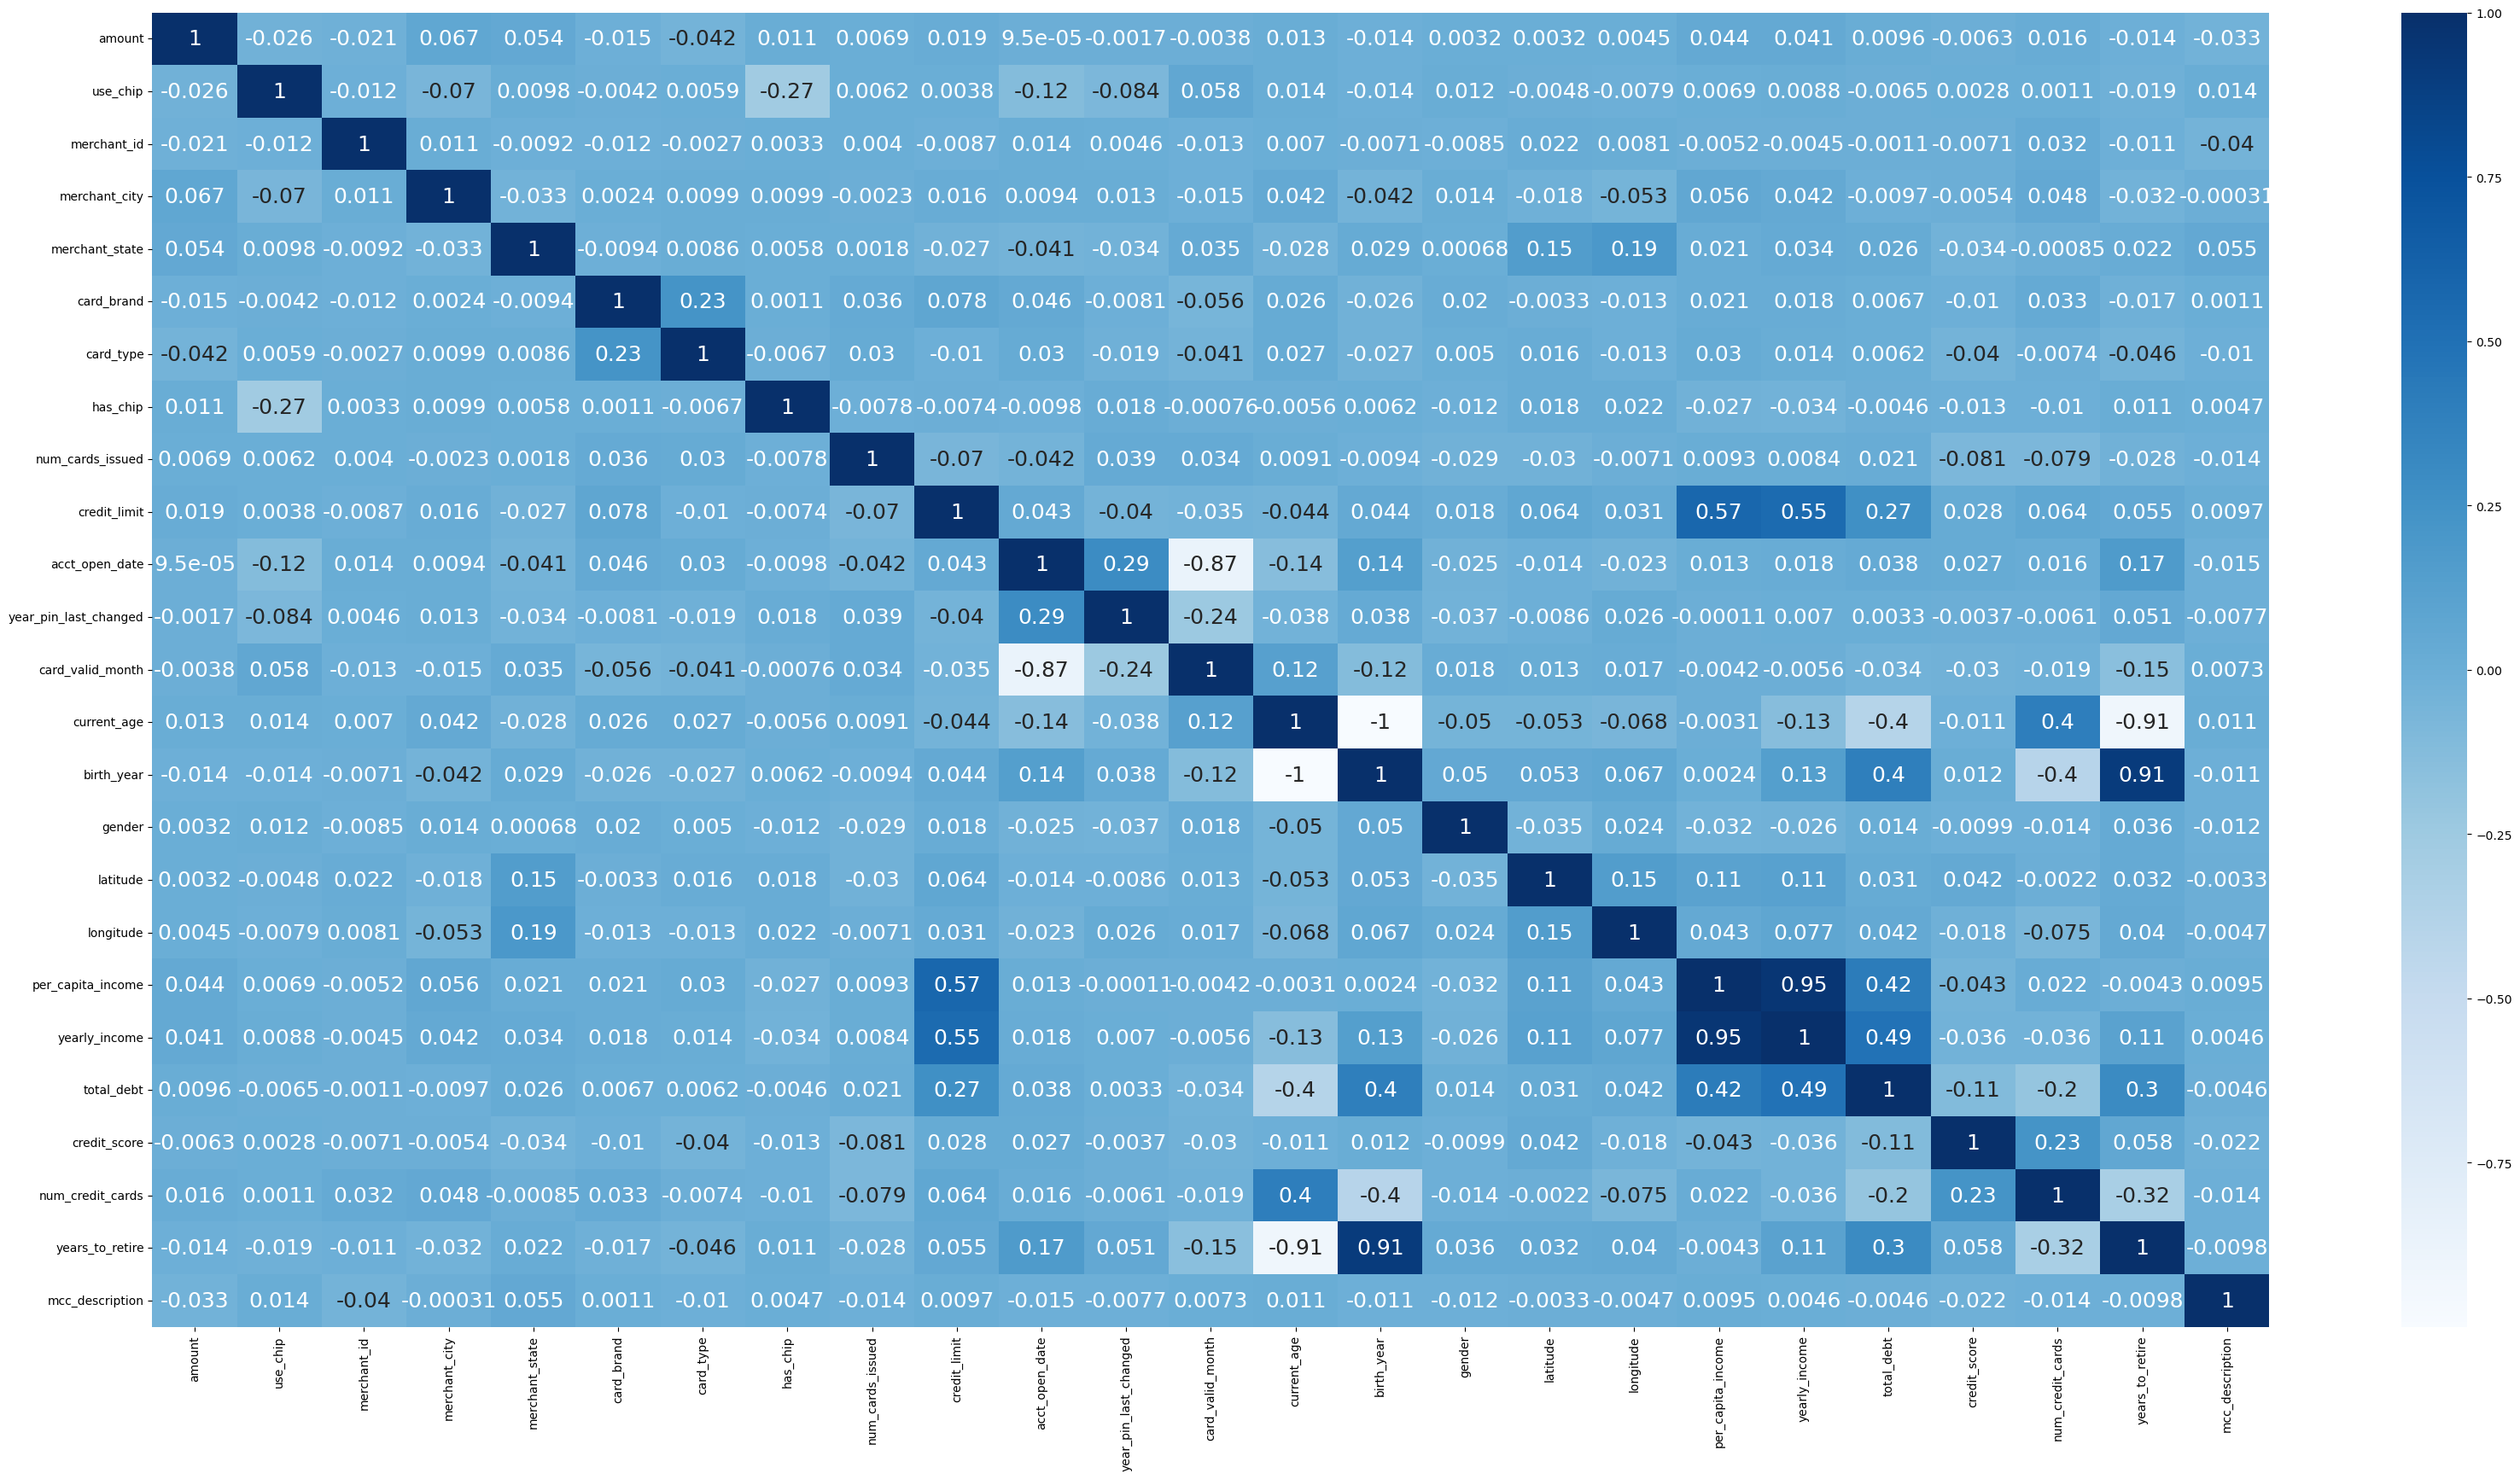

In [8]:
plt.figure(figsize=(40,20))
ax = sns.heatmap(x_res[x_res.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

eliminare le correlazioni con valore maggiore di 0.8

In [9]:
import numpy as np

# Calcola la matrice di correlazione (senza abs)
corr_matrix = x.corr()

# Considera solo la metà superiore della matrice
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

for col in upper.columns:
    for row in upper.index:
        corr_value = upper.loc[row, col]
        if abs(corr_value) > 0.8:
            print(f"{row} vs {col}: correlazione = {corr_value:.2f}")
        

acct_open_date vs card_valid_month: correlazione = -0.87
current_age vs birth_year: correlazione = -1.00
per_capita_income vs yearly_income: correlazione = 0.95
current_age vs years_to_retire: correlazione = -0.91
birth_year vs years_to_retire: correlazione = 0.91


In [8]:
x_res.drop(['years_to_retire','birth_year','card_valid_month','per_capita_income'], axis=1, inplace=True)

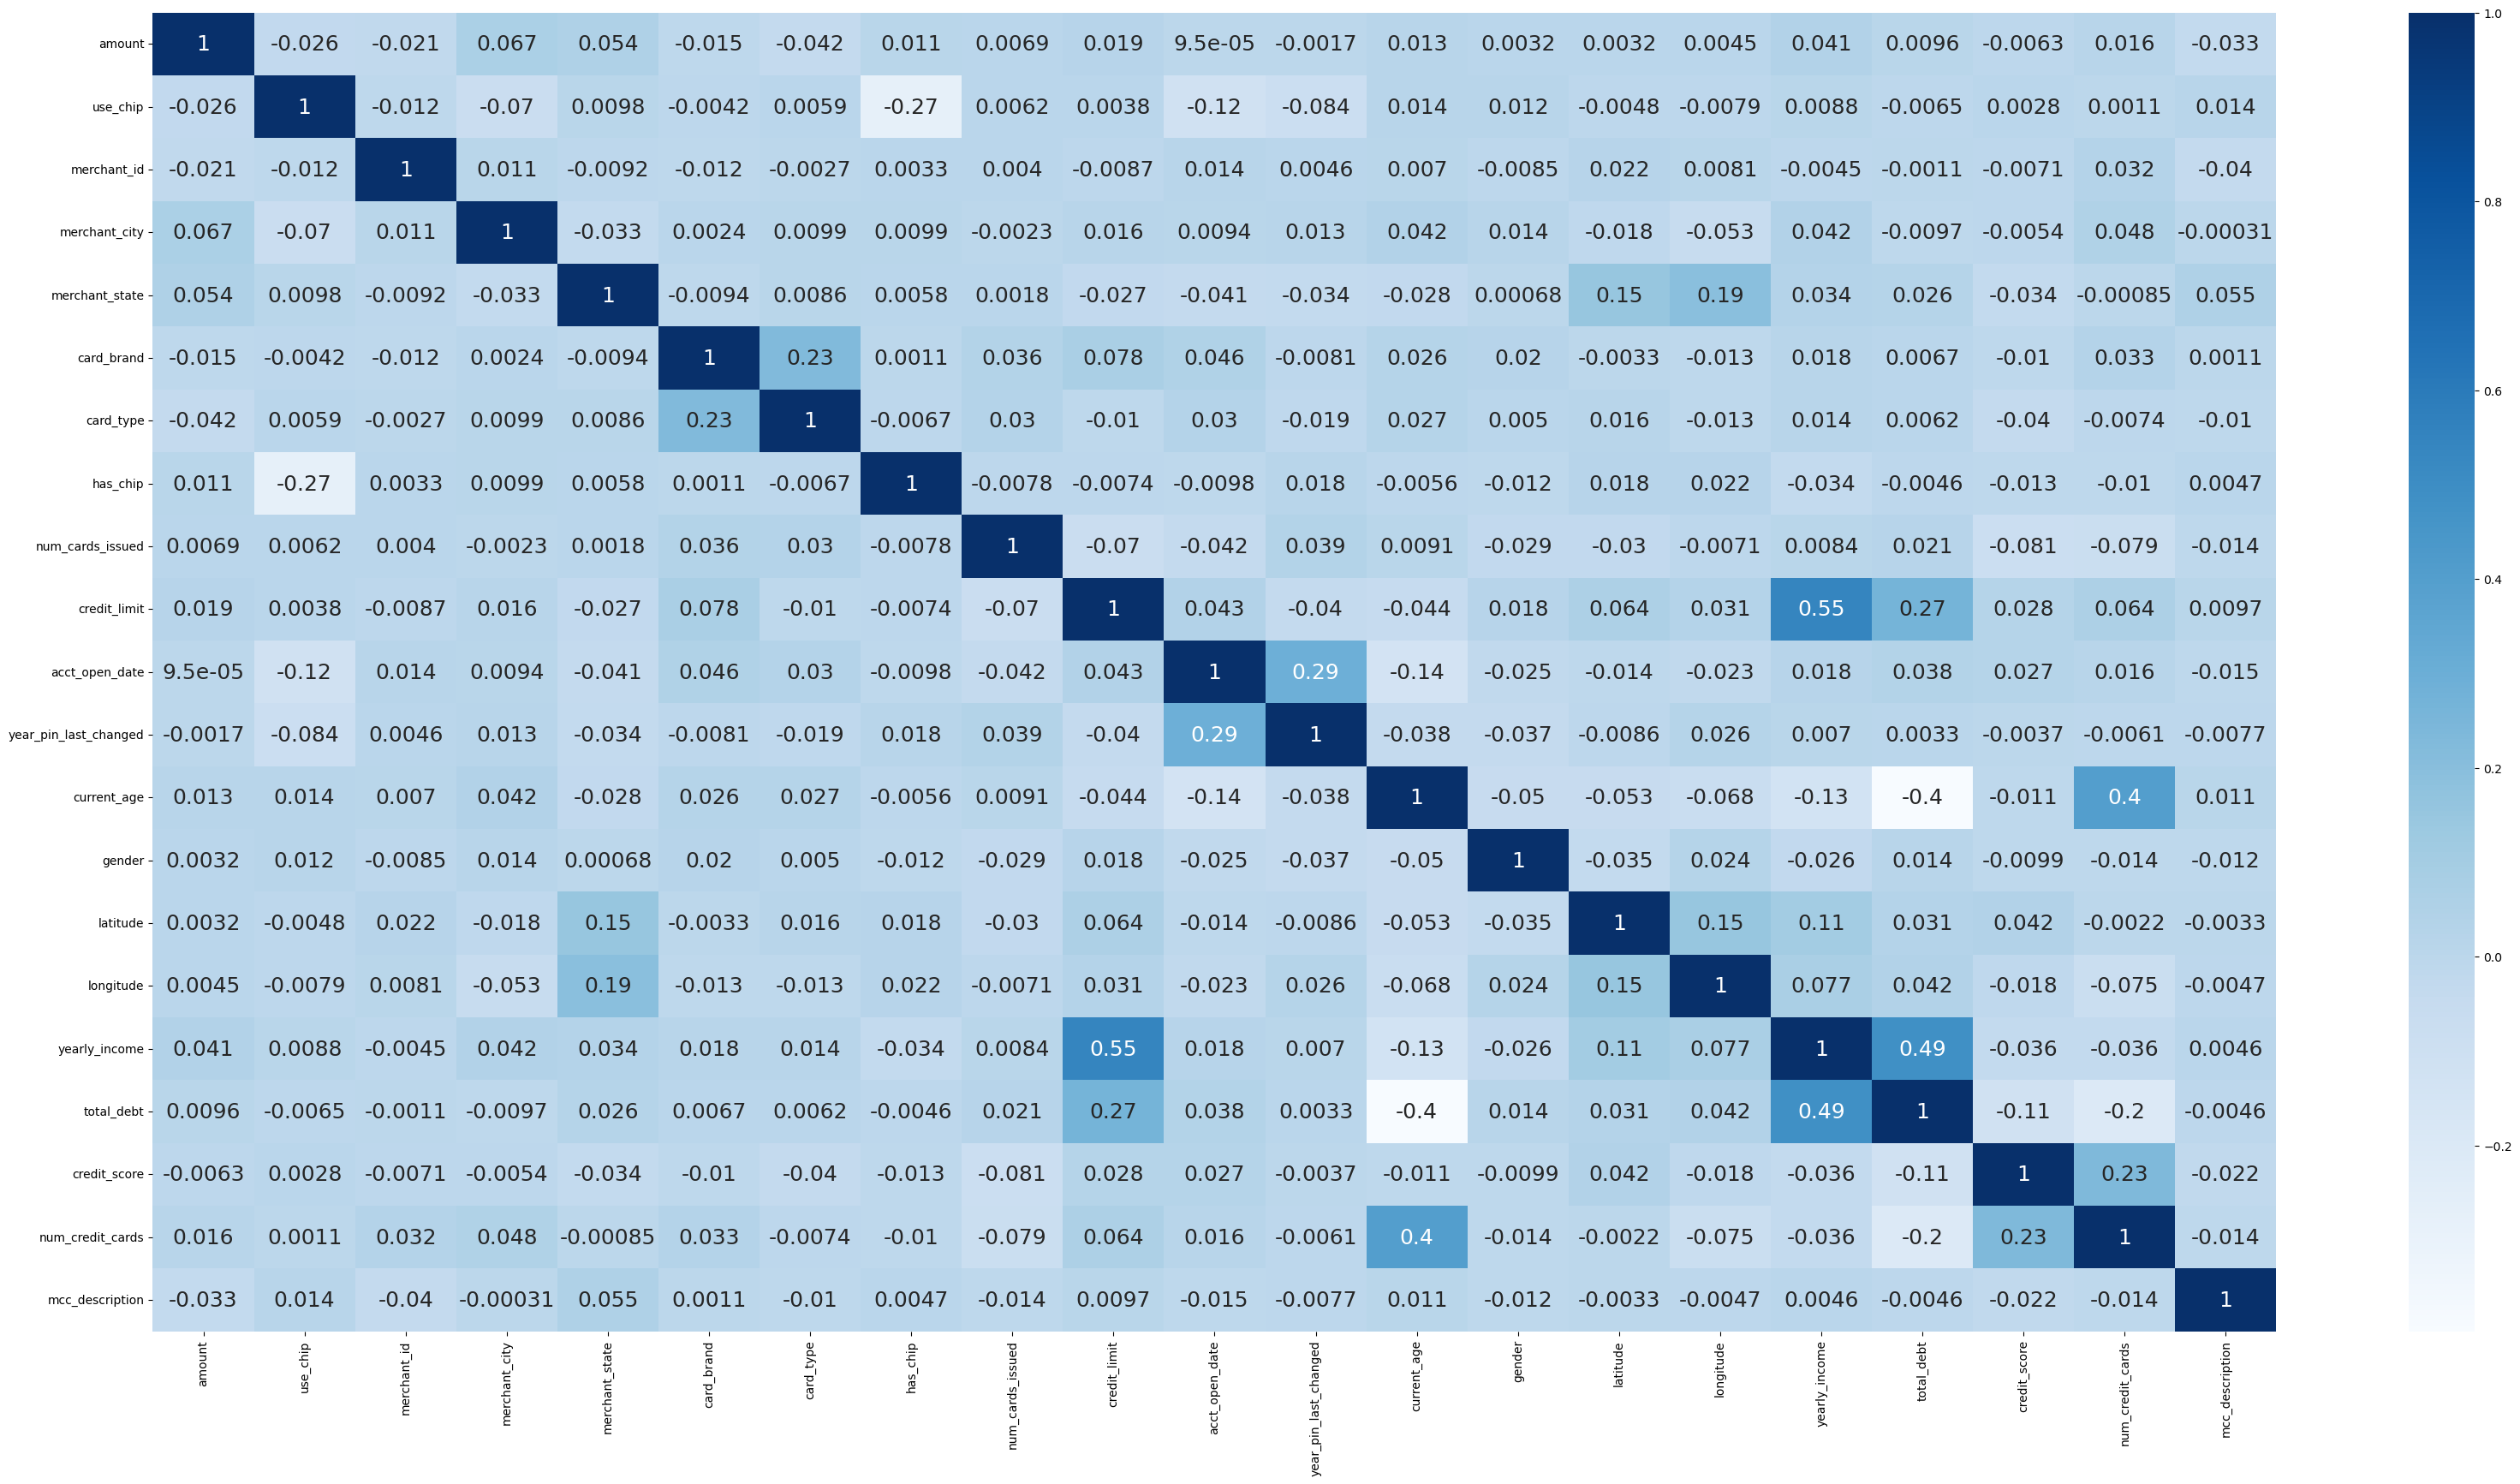

In [12]:
plt.figure(figsize=(40,20))
ax = sns.heatmap(x_res[x_res.columns].corr(),cmap="Blues",annot=True,annot_kws={"size": 18})

In [9]:
x_res.head(10)

,amount,use_chip,merchant_id,merchant_city,merchant_state,card_brand,card_type,has_chip,num_cards_issued,credit_limit,...,year_pin_last_changed,current_age,gender,latitude,longitude,yearly_income,total_debt,credit_score,num_credit_cards,mcc_description
9060707,52.680000,0,19114.0,9061,123,3,1,1,2,29573.0,...,2009,45,1,40.720001,-73.860001,51196.0,67164.0,631,4,34
2111603,167.199997,1,9932.0,7822,132,3,0,1,2,6400.0,...,2010,47,0,43.230000,-77.059998,34057.0,59247.0,655,4,26
2231752,15.210000,2,25887.0,3473,130,3,0,1,2,13200.0,...,2011,55,0,39.330002,-84.540001,44839.0,63194.0,625,3,39
8181621,10.200000,0,50783.0,1894,69,0,0,1,2,11300.0,...,2008,56,1,41.830002,-87.680000,36335.0,28929.0,676,2,45
7075728,209.000000,0,44795.0,224,1,3,0,1,1,10300.0,...,2016,37,0,33.720001,-84.320000,49335.0,51520.0,773,3,21
9547187,12.660000,0,79659.0,1714,172,3,1,1,2,22641.0,...,2011,49,0,30.510000,-97.830002,62019.0,85666.0,543,4,77
1358020,80.000000,2,27092.0,6196,24,2,1,1,2,4598.0,...,2017,68,1,34.040001,-118.209999,11566.0,9102.0,536,4,70
3828216,3.400000,2,61195.0,1239,123,2,1,1,1,14541.0,...,2011,42,1,40.639999,-73.940002,47542.0,2667.0,725,3,87
13210513,51.209999,0,69956.0,719,69,2,1,1,1,20447.0,...,2017,41,1,38.529999,-90.000000,49967.0,58582.0,712,4,30
11393761,68.000000,0,59935.0,11027,53,2,2,1,1,96.0,...,2011,73,1,33.849998,-84.220001,34220.0,0.0,745,5,64


## CLASSIFICAZIONE

In [9]:
# Random state
rs = 42

# Split the data to check which algorithms learn better (later on we can check )
x_train, x_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.2, random_state=rs)

# look at the shape of the data (many problems can arise from wrong shape)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(42662, 21)
(10666, 21)
(42662,)
(10666,)


In [ ]:
y_train.value_counts()

definizione classificatori facendo standardizzazione delle feature per svc, logistic regression e linear discriminant analysis altrimenti non funziona

In [10]:
# List of classifiers:
classifiers = [
     ("LogisticRegression", Pipeline([
          ('scaler', StandardScaler()),
          ('clf',    LogisticRegression(random_state=rs))
     ])),
     ("DecisionTreeClassifier", DecisionTreeClassifier(random_state=rs)),
     ("RandomForestClassifier", RandomForestClassifier(n_estimators=10, random_state=rs)),
     ("AdaBoostClassifier",     AdaBoostClassifier()),
     ("GradientBoostingClassifier", GradientBoostingClassifier(n_estimators=10, random_state=rs)),
     ("LinearDiscriminantAnalysis", Pipeline([
          ('scaler', StandardScaler()),
          ('clf',    LinearDiscriminantAnalysis())
     ])),
     ("SVC", Pipeline([
          ('scaler', StandardScaler()),
          ('clf',    SVC(probability=True, random_state=rs))
     ]))
]

# NB
# 1. In questo caso usiamo standardizzazione per SVC e LogisticRegression perché a differenza degli altri hanno bisogno di feature scaling essendo modelli lineari

# List of results that will occure:
clf_name = [] # names of the classifiers
model_results = y_test.to_frame(name="fraud") #resulting of prediction from the models

kfold = StratifiedKFold(n_splits=5) #cross-validation
cv_results = [] # scores from cross validation
cv_acc = [] # mean accuracy from cross validation, need to maximize
cv_std = [] # standard deviation from cross validation, need to minimise

cnfm = [] #confusion matrix
clr = [] #classification report
roc_auc = [] #roc curve:
roc_tpr = []
roc_fpr = []

In [27]:
print(type(model_results))

<class 'pandas.core.frame.DataFrame'>


training dei classificatori

In [11]:
for name, clf in classifiers:
    clf_name.append(name)
    
    #fitting and predictions
    model = clf.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    model_results[name] = y_pred
    
    #accuracy and log loss
    cv_results.append(cross_val_score(clf, x_train, y_train, scoring = "accuracy",cv = kfold))
    acc = round(accuracy_score(y_test, y_pred), 2) #need to maximize
    train_pred = clf.predict_proba(x_test)
    print(f'Accuracy: {acc} \t ---> {name} ')
    
    #confusion matrix, clasification report, roc curve
    cnfm.append(confusion_matrix(y_test, y_pred))
    clr.append(classification_report(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_pred, y_test)
    roc_auc.append(auc(fpr, tpr))
    roc_tpr.append(tpr)
    roc_fpr.append(fpr)
    

for i in cv_results:
    cv_acc.append(i.mean())
    cv_std.append(i.std())

Accuracy: 0.76 	 ---> LogisticRegression 
Accuracy: 0.95 	 ---> DecisionTreeClassifier 
Accuracy: 0.96 	 ---> RandomForestClassifier 
Accuracy: 0.94 	 ---> AdaBoostClassifier 
Accuracy: 0.92 	 ---> GradientBoostingClassifier 
Accuracy: 0.76 	 ---> LinearDiscriminantAnalysis 
Accuracy: 0.9 	 ---> SVC 


il problema per LR e LDA è dato da

Label encoding converte le categorie in numeri interi (es. ["cat", "dog", "fish"] → [0, 1, 2]).Ma in realtà, tra “cat” e “dog” non c’è un ordine → quindi il modello apprende relazioni false.

I modelli lineari (LR, LDA) e SVC assumono relazioni ordinali tra i numeri.



Conseguenza:

Le decision boundary saranno distorte.

Le performance dei modelli lineari e basati su distanza peggiorano.

In [46]:
# Cross validation accuracy results graph
cv_res = pd.DataFrame({"CrossValMeans":cv_acc, "CrossValerrors": cv_std,"Algorithm":clf_name})
cv_res.head(10)

,CrossValMeans,CrossValerrors,Algorithm
0,0.765623,0.001456,LogisticRegression
1,0.951878,0.001952,DecisionTreeClassifier
2,0.959683,0.002323,RandomForestClassifier
3,0.941775,0.002513,AdaBoostClassifier
4,0.919577,0.002251,GradientBoostingClassifier
5,0.764873,0.001577,LinearDiscriminantAnalysis
6,0.906076,0.002117,SVC


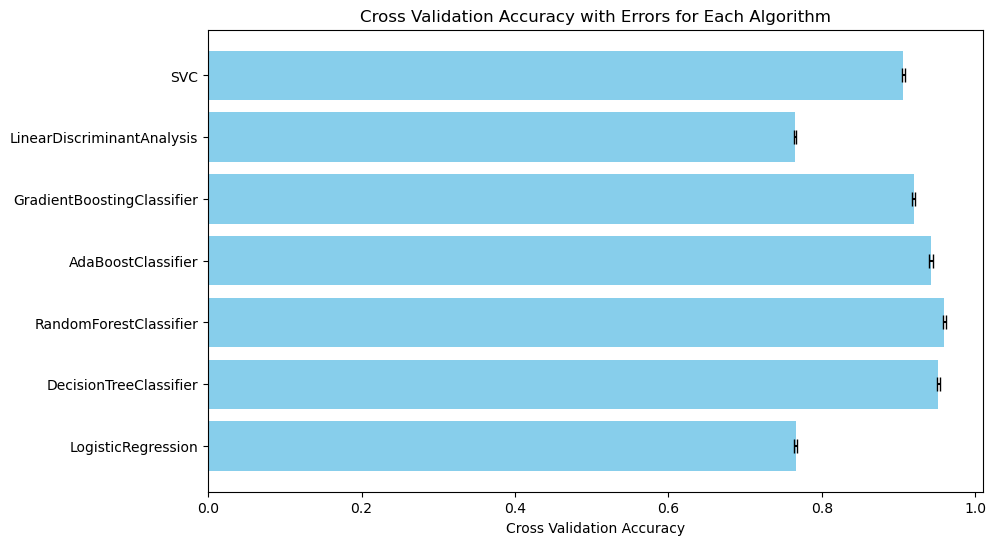

In [47]:
# Creazione del DataFrame
cv_res = pd.DataFrame({"CrossValMeans": cv_acc, "CrossValerrors": cv_std, "Algorithm": clf_name})

# Creazione del barplot
plt.figure(figsize=(10, 6))
plt.barh(cv_res['Algorithm'], cv_res['CrossValMeans'], xerr=cv_res['CrossValerrors'], capsize=5, color='skyblue')
plt.xlabel('Cross Validation Accuracy')
plt.title('Cross Validation Accuracy with Errors for Each Algorithm')
plt.show()

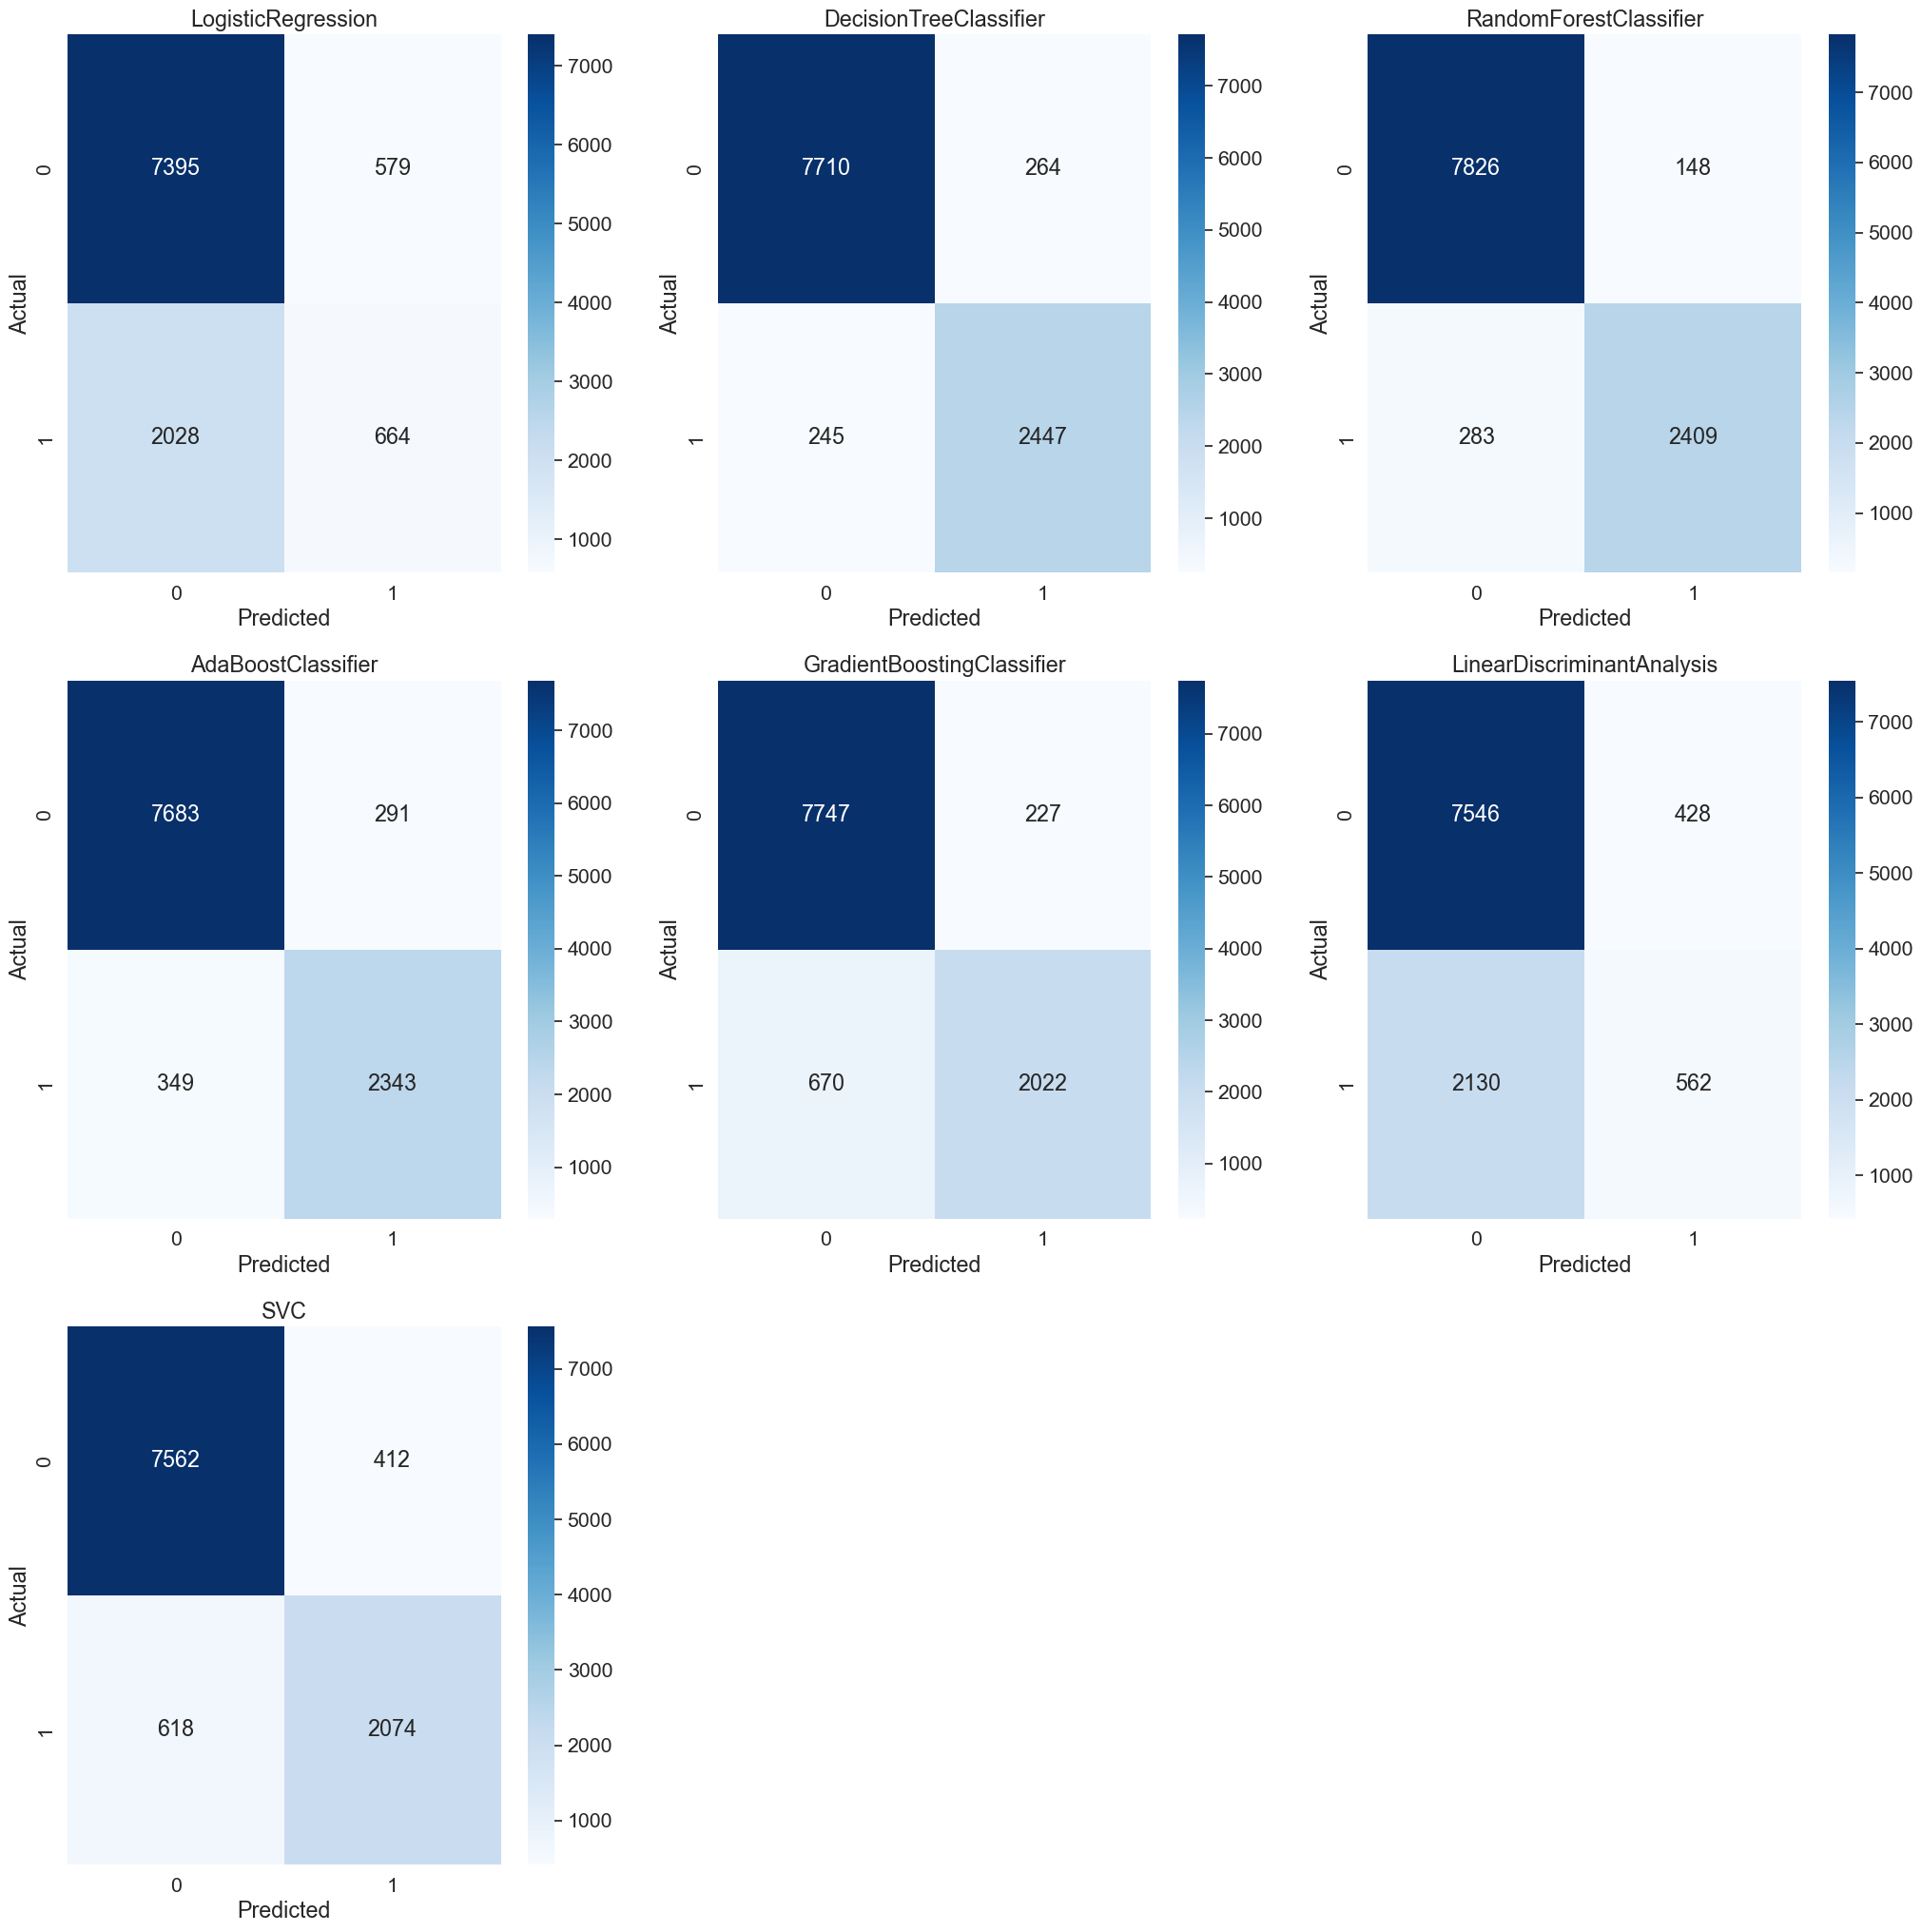

In [16]:
# Confusion matrixes (not-normalized confusion matrix)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.4)
for i in range(len(classifiers)):
    plt.subplot(3,3,i+1) #adjust this acourding to the number of algorithms
    sns.heatmap(cnfm[i], annot=True, fmt="d",cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(clf_name[i])

In [17]:
#Classification reports
for i in range(len(classifiers)):
    print (f"{clf_name[i]} Classification Report:" )
    print (clr[i])

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      7974
           1       0.53      0.25      0.34      2692

    accuracy                           0.76     10666
   macro avg       0.66      0.59      0.59     10666
weighted avg       0.72      0.76      0.72     10666

DecisionTreeClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7974
           1       0.90      0.91      0.91      2692

    accuracy                           0.95     10666
   macro avg       0.94      0.94      0.94     10666
weighted avg       0.95      0.95      0.95     10666

RandomForestClassifier Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      7974
           1       0.94      0.89      0.92      2692

    accuracy                           0.96     

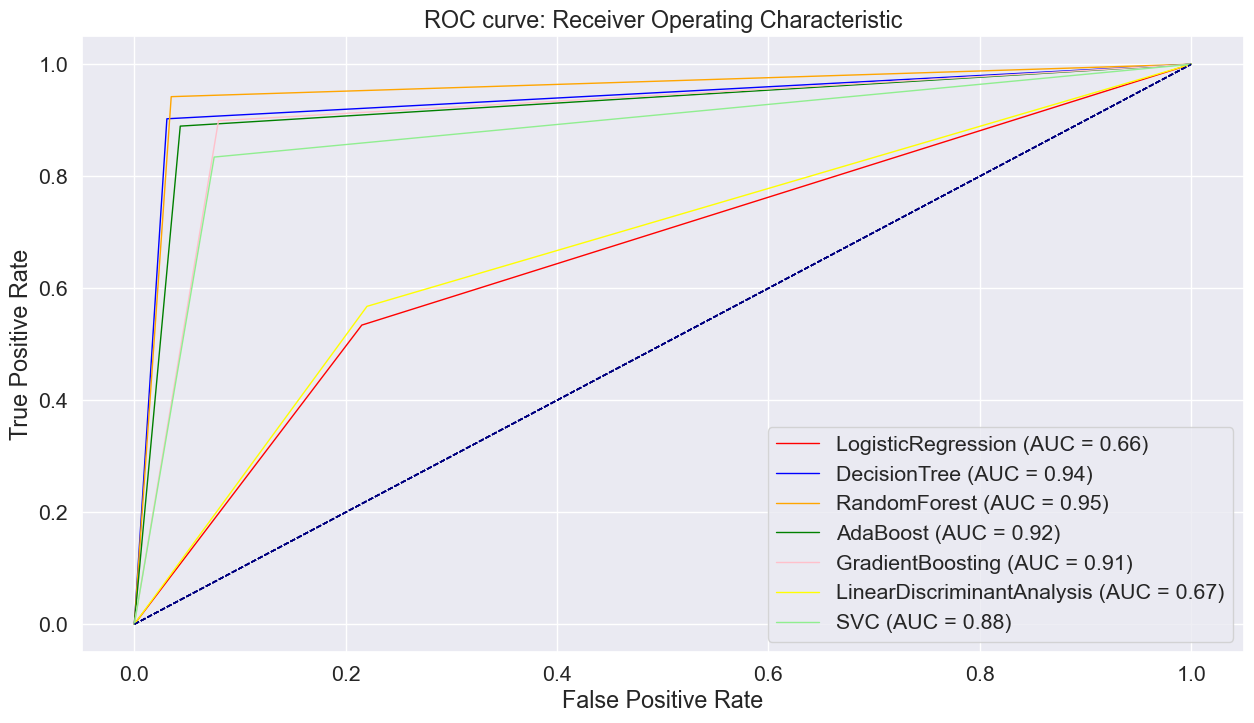

In [ ]:
# ROC Curve
plt.figure(figsize=(15,8))
for i in range(len(classifiers)):
    cm = ['red', 'blue', 'orange', 'green', 'pink', 'yellow', 'lightgreen', 'black', 'purple', 'lightblue'] #add more colours for more algorithms
    plt.plot(roc_fpr[i], roc_tpr[i], c=cm[i], lw=1, label=clf_name[i].replace("Classifier", "") + " (AUC = " + str(round(roc_auc[i],2)) + ")")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Receiver Operating Characteristic')
    plt.legend(loc="lower right")

Visualizzazione correlazioni tra modelli per scegliere su quali modelli fare grid search e poi model ensemble

Text(0.5, 1.0, 'Correlation between models')

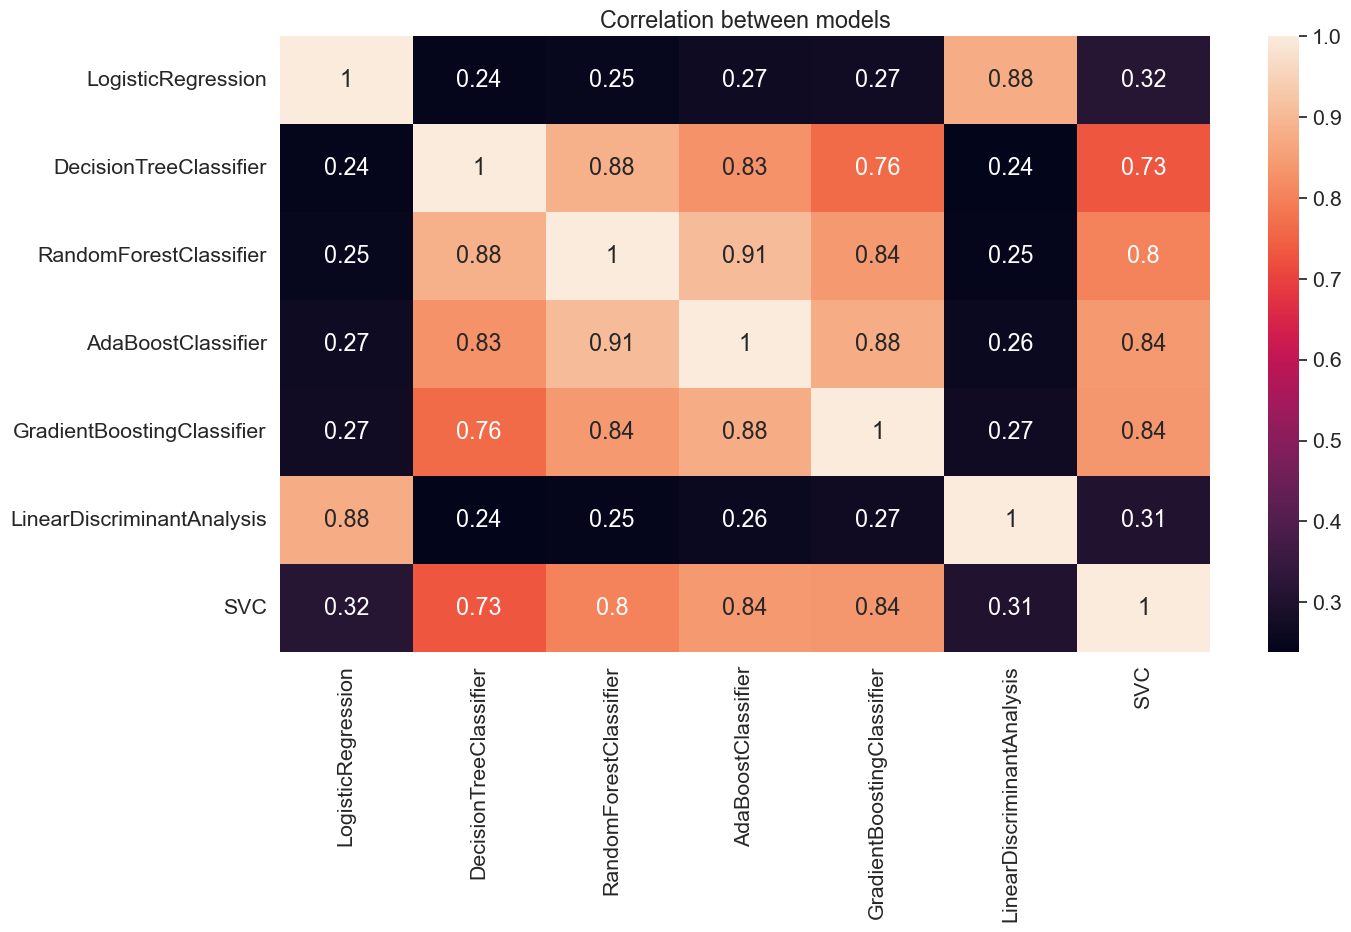

In [19]:
# Check for correlation between models: Make a correlation graph
plt.figure(figsize=(15,8))
sns.heatmap(model_results.drop("fraud", axis=1).corr(),annot=True)
plt.title("Correlation between models")

## GRID SEARCH

si fa la grid search di modelli con scarsa correlazione perché poi il model ensemble ha senso quando:

Prestazioni non ancora soddisfacenti
– Se il miglior modello singolo non raggiunge l’accuratezza desiderata, un ensemble può spesso dare un ulteriore boost.
– Utile soprattutto quando sei già vicino al limite “intrinseco” del dataset e hai bisogno di quel “percentile” in più di performance.

Errori complementari tra modelli
– Se due o più modelli sbagliano su istanze diverse (bassa correlazione nei loro errori), combinandoli ottieni un voto più affidabile.

non usiamo modelli lineari poiché non adatti a questo dataset, sarebbe inutile poi fare ensamble

In [12]:
# Search grid for optimal parameters

GB_param = {
    'n_estimators':    [50, 100, 200],
    'learning_rate':   [0.01, 0.1, 0.2],
    'max_depth':       [3, 5, 7],
    'subsample':       [0.6, 0.8, 1.0]
}

DT_param = {
    "max_depth": [2,3,8,10],
    "max_features": [0.3, 0.7, 1],
    "min_samples_split": [2, 3, 10],
    "min_samples_leaf": [1, 3, 10],
    "criterion": ["gini"]
}

#using 4 n_jobs for faster processing
GBgs = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=rs),
    param_grid=GB_param,
    cv=kfold,
    scoring="accuracy",
    n_jobs=4,
    verbose=1
)
DTgs = GridSearchCV(DecisionTreeClassifier(), param_grid=DT_param, cv=kfold, n_jobs=4, scoring="accuracy", verbose = 1)

models = [GBgs, DTgs]

gs_model = []
score = []

for model in models:
    model.fit(x_train, y_train)
    gs_model.append(model.best_estimator_)
    score.append(model.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [30]:
print(cv_acc)
print(classifiers)

[0.7656228000731173, 0.9518775016978566, 0.9596830352627281, 0.9417747781440786, 0.9195770657136583, 0.7648727268212009, 0.9060756125703529]
[('LogisticRegression', Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(random_state=42))])), ('DecisionTreeClassifier', DecisionTreeClassifier(random_state=42)), ('RandomForestClassifier', RandomForestClassifier(n_estimators=10, random_state=42)), ('AdaBoostClassifier', AdaBoostClassifier()), ('GradientBoostingClassifier', GradientBoostingClassifier(n_estimators=10, random_state=42)), ('LinearDiscriminantAnalysis', Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LinearDiscriminantAnalysis())])), ('SVC', Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', SVC(probability=True, random_state=42))]))]


In [15]:
# scores without gridsearch
print("score without GridSearchCV: ", round(cv_acc[4], 3), round(cv_acc[1], 3))
# scores with gridsearch
print("score with GridSearchCV: ", round(score[0], 3), round(score[1], 3))

score without GridSearchCV:  0.92 0.952
score with GridSearchCV:  0.971 0.957


## MODEL ENSEMBLE

In [13]:
# Do model ensembling

best_model = VotingClassifier(estimators=[('gb', gs_model[0]), ('dt', gs_model[1])], 
                              voting='soft', n_jobs=4)
best_model.fit(x_train,y_train)
print(accuracy_score(y_test,best_model.predict(x_test)))

0.9675604725295331


In [ ]:
# Salva su file
with open('best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

### YELLOWBRICK

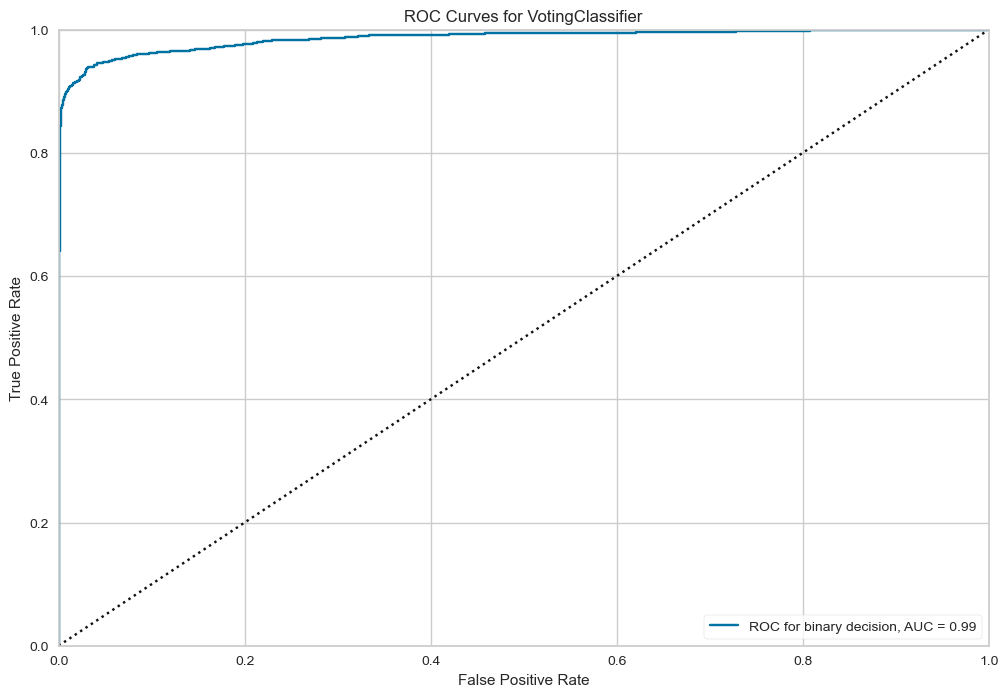

<Axes: title={'center': 'ROC Curves for VotingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [ ]:
# Instantiate the visualizer with the classification model
plt.figure(figsize=(12,8))
visualizer = ROCAUC(best_model, classes=["not_survived", "survived"], micro=False, macro=False, binary=True)
visualizer.fit(x_train, y_train)        # Fit the training data to the visualizer
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure

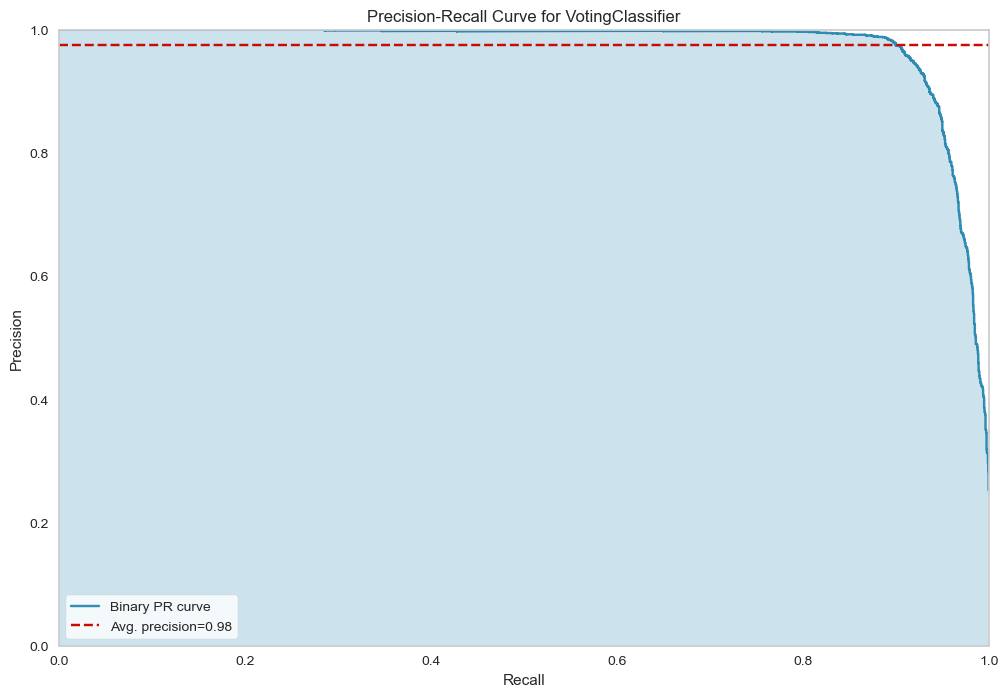

<Axes: title={'center': 'Precision-Recall Curve for VotingClassifier'}, xlabel='Recall', ylabel='Precision'>

In [ ]:
plt.figure(figsize=(12,8))
# Create the visualizer, fit, score, and show it
viz = PrecisionRecallCurve(best_model)
viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show()

In [ ]:
# Cancella tutte le altre variabili nello spazio globale
for var in list(globals()):
    del globals()[var]
    
with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'best_model.pkl'

In [ ]:
# Create the learning curve visualizer
cv = StratifiedKFold(n_splits=5)
sizes = np.linspace(0.3, 1.0, 10)

plt.figure(figsize=(12,8))
visualizer = LearningCurve(
    best_model, cv=cv, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
)

visualizer.fit(x, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

NameError: name 'best_model' is not defined

<Figure size 1200x800 with 0 Axes>